Index
- 1. Design mOR candidate
- 2. Design fentanyl binding peptide

# 1. Design a mu Opioid Receptor candidate(mOR)

## Set up the notebook and model (via the Forge API).

We begin by installing the [esm package](https://github.com/evolutionaryscale/esm) and py3Dmol, which will allow us to visualize our generations, and then importing necessary packages.

In [1]:
from IPython.display import clear_output

!pip install git+https://github.com/evolutionaryscale/esm.git
!pip install py3Dmol

clear_output()  # Suppress pip install log lines after installation is complete.

In [2]:
from getpass import getpass

import biotite.sequence as seq
import biotite.sequence.align as align
import biotite.sequence.graphics as graphics
import matplotlib.pyplot as pl
import py3Dmol
import torch
from esm.sdk import client
from esm.sdk.api import ESMProtein, GenerationConfig
from esm.utils.structure.protein_chain import ProteinChain


ESM3 is a frontier generative model for biology. It is  scalable due to its ability to tokenize sequence, structure, and function and use a (nearly standard) transformer architecture while still being able to reason across all modalities simulateously.

The largest ESM3 (98 billion parameters) was trained with 1.07e24 FLOPs on 2.78 billion proteins and 771 billion unique tokens. To create esmGFP we used the 7 billion parameter variant of ESM3. We'll use this model via the [EvolutionaryScale Forge](https://forge.evolutionaryscale.ai) API.

Grab a token from [the Forge console](https://forge.evolutionaryscale.ai/console) and add it below. Note that your token is like a password for your account and you should take care to protect it. For this reason it is recommended to frequently create a new token and delete old, unused ones. It is also recommended to paste the token directly into an environment variable or use a utility like `getpass` as shown below so tokens are not accidentally shared or checked into code repositories.

In [3]:
token = getpass("Token from Forge console: ")

Token from Forge console: ··········


In [4]:
model = client(
    model="esm3-medium-2024-03", url="https://forge.evolutionaryscale.ai", token=token
)

## Construct the mOR Prompt


In [5]:
template_Opioid = ESMProtein.from_protein_chain(
    ProteinChain.from_rcsb("5C1M", chain_id="A")
)

template_Opioid_tokens = model.encode(template_Opioid)

print("Sequence tokens:")
print(
    "    ", ", ".join([str(token) for token in template_Opioid_tokens.sequence.tolist()])
)

print("Structure tokens:")
print(
    "    ", ", ".join([str(token) for token in template_Opioid_tokens.structure.tolist()])
)

Sequence tokens:
     0, 6, 8, 21, 8, 4, 14, 16, 11, 6, 8, 14, 8, 20, 7, 11, 5, 12, 11, 12, 20, 5, 4, 19, 8, 12, 7, 23, 7, 7, 6, 4, 18, 6, 17, 18, 4, 7, 20, 19, 7, 12, 7, 10, 19, 11, 15, 20, 15, 11, 5, 11, 17, 12, 19, 12, 18, 17, 4, 5, 4, 5, 13, 5, 4, 5, 11, 8, 11, 4, 14, 18, 16, 8, 7, 17, 19, 4, 20, 6, 11, 22, 14, 18, 6, 17, 12, 4, 23, 15, 12, 7, 12, 8, 12, 13, 19, 19, 17, 20, 18, 11, 8, 12, 18, 11, 4, 23, 11, 20, 8, 7, 13, 10, 19, 12, 5, 7, 23, 21, 14, 7, 15, 5, 4, 13, 18, 10, 11, 14, 10, 17, 5, 15, 12, 7, 17, 7, 23, 17, 22, 12, 4, 8, 8, 5, 12, 6, 4, 14, 7, 20, 18, 20, 5, 11, 11, 15, 19, 10, 16, 6, 8, 12, 13, 23, 11, 4, 11, 18, 8, 21, 14, 11, 22, 19, 22, 9, 17, 4, 4, 15, 12, 23, 7, 18, 12, 18, 5, 18, 12, 20, 14, 7, 4, 12, 12, 11, 7, 23, 19, 6, 4, 20, 12, 4, 10, 4, 15, 8, 7, 10, 20, 4, 8, 6, 8, 15, 9, 15, 13, 10, 17, 4, 10, 10, 12, 11, 10, 20, 7, 4, 7, 7, 7, 5, 7, 18, 12, 7, 23, 22, 11, 14, 12, 21, 12, 19, 7, 12, 12, 15, 5, 4, 12, 11, 12, 14, 9, 11, 11, 18, 16, 11, 7, 8, 22, 21, 18, 2

In [37]:
import random

In [40]:
structures_ = []
structures_refold = []
round_trip= []

In [42]:
temp=[0.5, 0.6, 0.7, 0.8]
round_trip = []
for iter in range(25):
  print(f"iter {iter}")
  num_tokens_to_decode = (prompt.structure == 4096).sum().item()

  structure_generation = model.generate(
      prompt,
      GenerationConfig(
          # Generate a structure.
          track="structure",
          # Sample one token per forward pass of the model.
          num_steps=num_tokens_to_decode,
          # Sampling temperature trades perplexity with diversity.
          temperature=random.choice(temp)
      ),
  )

  print("These are the structure tokens corresponding to our new design:")
  print(
      "    ", ", ".join([str(token) for token in structure_generation.structure.tolist()])
  )

  # Decodes structure tokens to backbone coordinates.
  structure_generation_protein = model.decode(structure_generation)
  print(f"Structure generation ptm: {structure_generation_protein.ptm}")
  structures_.append(structure_generation)
  constrained_site_positions = [2,71,90,91,94,95,98,183,240,243,244,247,265,269,273]
  template_chain = template_Opioid.to_protein_chain()
  generation_chain = structure_generation_protein.to_protein_chain()

  constrained_site_rmsd_seq = template_chain[constrained_site_positions].rmsd(
      generation_chain[constrained_site_positions]
  )
  backbone_rmsd = template_chain.rmsd(generation_chain)

  c_pass = "✅" if constrained_site_rmsd_seq < 1.5 else "❌"
  b_pass = "✅" if backbone_rmsd > 1.5 else "❌"
  print(f"Sequence generation ptm: {sequence_generation_protein.ptm}")
  print(f"Constrained site RMSD: {constrained_site_rmsd_seq:.2f} Ang {c_pass}")
  print(f"Backbone RMSD: {backbone_rmsd:.2f} Ang {b_pass}")

  num_tokens_to_decode = (prompt.sequence == 32).sum().item()

  sequence_generation = model.generate(
        # Generate a sequence.
        structure_generation,
        GenerationConfig(track="sequence", num_steps=num_tokens_to_decode, temperature=1.0),
    )

  # Refold
  sequence_generation.structure = None
  length_of_sequence = sequence_generation.sequence.numel() - 2
  sequence_generation = model.generate(
      sequence_generation,
      GenerationConfig(track="structure", num_steps=length_of_sequence, temperature=0.0),
  )

  # Decode to AA string and coordinates.
  sequence_generation_protein = model.decode(sequence_generation)

  structures_refold.append(sequence_generation)
  template_chain = template_Opioid.to_protein_chain()
  generation_chain = sequence_generation_protein.to_protein_chain()

  constrained_site_rmsd_refold = template_chain[constrained_site_positions].rmsd(
      generation_chain[constrained_site_positions]
  )
  backbone_rmsd = template_chain.rmsd(generation_chain)

  c_pass = "✅" if constrained_site_rmsd_refold < 1.5 else "❌"
  b_pass = "🤷‍♂️"
  print(f"Sequence generation ptm: {sequence_generation_protein.ptm}")
  print(f"Constrained site RMSD: {constrained_site_rmsd:.2f} Ang {c_pass}")
  print(f"Backbone RMSD: {backbone_rmsd:.2f} Ang {b_pass}")

  sequence_generation_protein.to_pdb(f"muopioid_gen{iter}.pdb")
  round_trip.append({"sequence": sequence_generation_protein.sequence, "ptm_structgen": structure_generation_protein.ptm.tolist(), "rmsd_structgen": constrained_site_rmsd_seq, "ptm_refold" : sequence_generation_protein.ptm.tolist(), "rmsd_refold": constrained_site_rmsd_refold})

  print(f"Done iter{iter}")
  print()

iter 0
These are the structure tokens corresponding to our new design:
     4098, 1485, 483, 3189, 3146, 1918, 1189, 1322, 903, 3189, 2632, 1585, 2938, 3789, 2869, 1774, 3077, 3528, 441, 3321, 588, 2043, 2841, 3243, 588, 507, 2841, 182, 544, 2038, 3958, 3535, 1079, 3534, 3145, 1352, 1079, 689, 2585, 722, 1438, 3259, 3902, 1678, 1542, 2801, 334, 874, 1945, 51, 1382, 2366, 3584, 3958, 2546, 704, 2292, 3130, 3807, 2617, 3693, 3222, 3417, 240, 3958, 752, 4, 1105, 1441, 3815, 1750, 1522, 1297, 752, 3607, 2491, 2215, 3702, 1185, 2718, 81, 2502, 690, 3552, 1541, 3457, 116, 156, 193, 3237, 3056, 2675, 2957, 2841, 513, 1999, 3455, 3179, 3348, 1472, 4053, 3958, 3133, 3242, 1387, 3240, 3097, 996, 32, 3960, 3914, 149, 1069, 451, 2392, 2537, 2222, 3392, 1579, 3816, 2056, 3056, 2874, 1972, 4081, 3211, 808, 978, 2667, 3514, 433, 264, 372, 790, 2605, 498, 1736, 2056, 1352, 1058, 3045, 588, 2303, 2596, 1495, 3528, 3545, 2215, 690, 1019, 916, 1022, 3988, 1154, 2896, 3560, 1987, 2377, 99, 2369, 3611, 325

In [46]:
import pandas as pd


In [45]:
df = pd.DataFrame(round_trip)
df.to_csv("muopioid_roundtrip.tsv", sep="\t", index=False)

In [6]:
prompt_sequence = ["_"] * len(template_Opioid.sequence)
prompt_sequence[2] = "H"
prompt_sequence[71] = "Q"
prompt_sequence[90] = "V"
prompt_sequence[91] = "I"
prompt_sequence[94] = "D"
prompt_sequence[95] = "Y"
prompt_sequence[98] = "M"
prompt_sequence[183] = "V"
prompt_sequence[240] = "W"
prompt_sequence[243] = "I"
prompt_sequence[244] = "H"
prompt_sequence[247] = "V"
prompt_sequence[265] = "W"
prompt_sequence[269] = "I"
prompt_sequence[273] = "Y"

prompt_sequence = "".join(prompt_sequence)

print(template_Opioid.sequence)
print(prompt_sequence)

prompt = model.encode(ESMProtein(sequence=prompt_sequence))

# We construct an empty structure track like |<bos> <mask> ... <mask> <eos>|...
prompt.structure = torch.full_like(prompt.sequence, 4096)
prompt.structure[0] = 4098
prompt.structure[-1] = 4097
# ... and then we fill in structure tokens at key residues near the alpha helix
# kink and at the stabilizing R and E positions on the beta barrel.
prompt.structure[1:4] = template_Opioid_tokens.structure[1:4]
prompt.structure[70:73] = template_Opioid_tokens.structure[70:73]

prompt.structure[89:100] = template_Opioid_tokens.structure[89:100]
prompt.structure[182:185] = template_Opioid_tokens.structure[182:185]
prompt.structure[238:249] = template_Opioid_tokens.structure[238:249]
prompt.structure[264:275] = template_Opioid_tokens.structure[264:275]


print("".join(["✔" if st < 4096 else "_" for st in prompt.structure]))

GSHSLPQTGSPSMVTAITIMALYSIVCVVGLFGNFLVMYVIVRYTKMKTATNIYIFNLALADALATSTLPFQSVNYLMGTWPFGNILCKIVISIDYYNMFTSIFTLCTMSVDRYIAVCHPVKALDFRTPRNAKIVNVCNWILSSAIGLPVMFMATTKYRQGSIDCTLTFSHPTWYWENLLKICVFIFAFIMPVLIITVCYGLMILRLKSVRMLSGSKEKDRNLRRITRMVLVVVAVFIVCWTPIHIYVIIKALITIPETTFQTVSWHFCIALGYTNSCLNPVLYAFLDENFKRCF
__H____________________________________________________________________Q__________________VI__DY__M____________________________________________________________________________________V________________________________________________________W__IH__V_________________W___I___Y_____________________
_✔✔✔__________________________________________________________________✔✔✔________________✔✔✔✔✔✔✔✔✔✔✔__________________________________________________________________________________✔✔✔_____________________________________________________✔✔✔✔✔✔✔✔✔✔✔_______________✔✔✔✔✔✔✔✔✔✔✔______________________


## Generate a Structure



In [7]:
%%time

num_tokens_to_decode = (prompt.structure == 4096).sum().item()

structure_generation = model.generate(
    prompt,
    GenerationConfig(
        # Generate a structure.
        track="structure",
        # Sample one token per forward pass of the model.
        num_steps=num_tokens_to_decode,
        # Sampling temperature trades perplexity with diversity.
        temperature=0.7,
    ),
)

print("These are the structure tokens corresponding to our new design:")
print(
    "    ", ", ".join([str(token) for token in structure_generation.structure.tolist()])
)

# Decodes structure tokens to backbone coordinates.
structure_generation_protein = model.decode(structure_generation)

print("")

These are the structure tokens corresponding to our new design:
     4098, 1485, 483, 3189, 1325, 56, 2732, 2862, 903, 1337, 2514, 2816, 3913, 1197, 2498, 2684, 803, 2279, 3486, 3222, 2605, 3813, 2841, 3296, 2082, 3802, 2841, 1542, 155, 2699, 571, 2495, 1559, 339, 3077, 1352, 507, 689, 3961, 1112, 547, 987, 2048, 4055, 1444, 1035, 3735, 3868, 3827, 51, 1469, 3900, 1254, 3546, 191, 2216, 2278, 3130, 2148, 1894, 2057, 4048, 3345, 3704, 34, 2297, 4089, 2613, 3700, 1512, 1750, 1522, 1297, 3858, 3310, 1997, 2694, 682, 2135, 3156, 4015, 12, 3218, 490, 3149, 1829, 953, 321, 1931, 3237, 3056, 2675, 2957, 2841, 513, 1999, 3455, 3179, 3348, 1472, 2132, 3873, 3251, 1883, 2132, 2884, 2390, 1039, 1837, 1529, 3914, 845, 40, 1714, 996, 824, 3132, 2404, 1, 4073, 416, 703, 2531, 2618, 3538, 885, 1471, 353, 2738, 3101, 974, 144, 2082, 2651, 696, 123, 9, 3348, 3049, 249, 3676, 2701, 3501, 1533, 1839, 2159, 249, 3676, 3809, 3099, 287, 777, 3526, 3149, 3447, 288, 2972, 1306, 1173, 3991, 3627, 1850, 2770, 3

In [19]:
view = py3Dmol.view(width=1000, height=500)
view.addModel(
    structure_generation_protein.to_protein_chain().infer_oxygen().to_pdb_string(),
    "pdb",
)
view.setStyle({"cartoon": {"color": "teal"}})
view.zoomTo()
view.show()

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [9]:
constrained_site_positions = [2,71,90,91,94,95,98,183,240,243,244,247,265,269,273]

template_chain = template_Opioid.to_protein_chain()
generation_chain = structure_generation_protein.to_protein_chain()

constrained_site_rmsd = template_chain[constrained_site_positions].rmsd(
    generation_chain[constrained_site_positions]
)
backbone_rmsd = template_chain.rmsd(generation_chain)

c_pass = "✅" if constrained_site_rmsd < 1.5 else "❌"
b_pass = "✅" if backbone_rmsd > 1.5 else "❌"

print(f"Constrained site RMSD: {constrained_site_rmsd:.2f} Ang {c_pass}")
print(f"Backbone RMSD: {backbone_rmsd:.2f} Ang {b_pass}")

Constrained site RMSD: 2.12 Ang ❌
Backbone RMSD: 2.49 Ang ✅


# Sequence Design

Now we have a backbone with some structural variation but that also matches the GFP constrained site, and we want to design a sequence that folds to this structure. We can use the prior generation, which is exactly our original prompt plus the new structure tokens representing the backbone, to prompt ESM3 again.

One we have designed a sequence we'll want to confirm that sequence is a match for our structure, so we'll remove all other conditioning from the prompt and fold the sequence. Conveniently with ESM3, folding a sequence is simply generating a set of structure tokens conditioned on the amino acid sequence. In this case we want the model's highest confidence generation (with no diversity) so we sample with a temperature of zero.

In [10]:
%%time

num_tokens_to_decode = (prompt.sequence == 32).sum().item()

sequence_generation = model.generate(
    # Generate a sequence.
    structure_generation,
    GenerationConfig(track="sequence", num_steps=num_tokens_to_decode, temperature=1.0),
)

# Refold
sequence_generation.structure = None
length_of_sequence = sequence_generation.sequence.numel() - 2
sequence_generation = model.generate(
    sequence_generation,
    GenerationConfig(track="structure", num_steps=length_of_sequence, temperature=0.0),
)

# Decode to AA string and coordinates.
sequence_generation_protein = model.decode(sequence_generation)

CPU times: user 41 ms, sys: 3.98 ms, total: 44.9 ms
Wall time: 2min 16s


In [11]:
sequence_generation_protein.sequence

'MIHKPIYGLVPPEVYYCFAFVNFLVTLLGFPLNLLVMVVILRNKKLQTPTNYFILNLALADMLVAGIVLPIQFIYNLLQYWPFGPQMCVFVIFLDYLAMGAFIGSLMVISIDRFYAICHPHTRNRRHRRALLFILLSWLILVVALLGILAFISDCRVAPLPPGDLCFIDFYCEEEGAVALTIFVFLFAFLIPLVVITFCYGSVIRLLHEVIAKNPKSALQRREKYLTKLSVIVVVTFIICWAPIHGLVLYRLINYNDNDSVHPPIWCLTICLSYANSIFNPLIYGLKFNTKGGRL'

Sequence identity: 31.37%

Sequence alignment:


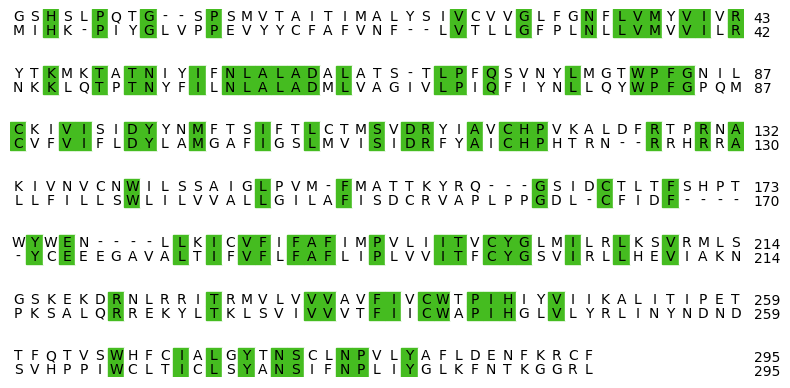

In [12]:
seq1 = seq.ProteinSequence(template_Opioid.sequence)
seq2 = seq.ProteinSequence(sequence_generation_protein.sequence)

alignments = align.align_optimal(
    seq1, seq2, align.SubstitutionMatrix.std_protein_matrix(), gap_penalty=(-10, -1)
)

alignment = alignments[0]

identity = align.get_sequence_identity(alignment)
print(f"Sequence identity: {100*identity:.2f}%")

print("\nSequence alignment:")
fig = pl.figure(figsize=(8.0, 4.0))
ax = fig.add_subplot(111)
graphics.plot_alignment_similarity_based(
    ax, alignment, symbols_per_line=45, spacing=2, show_numbers=True
)
fig.tight_layout()
pl.show()

In [13]:
template_chain = template_Opioid.to_protein_chain()
generation_chain = sequence_generation_protein.to_protein_chain()

constrained_site_rmsd = template_chain[constrained_site_positions].rmsd(
    generation_chain[constrained_site_positions]
)
backbone_rmsd = template_chain.rmsd(generation_chain)

c_pass = "✅" if constrained_site_rmsd < 1.5 else "❌"
b_pass = "🤷‍♂️"

print(f"Constrained site RMSD: {constrained_site_rmsd:.2f} Ang {c_pass}")
print(f"Backbone RMSD: {backbone_rmsd:.2f} Ang {b_pass}")

Constrained site RMSD: 1.99 Ang ❌
Backbone RMSD: 2.97 Ang 🤷‍♂️


An now we can visualize the final structure prediction of our candidate GFP design.

In [20]:
view = py3Dmol.view(width=600, height=600)
view.addModel(sequence_generation_protein.to_pdb_string(), "pdb")
view.setStyle({"cartoon": {"color": "teal"}})
view.zoomTo()
view.show()

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [25]:

print(structure_generation_protein.ptm)
print(sequence_generation_protein.sequence)
print(sequence_generation_protein.ptm)

tensor(0.8603)
MIHKPIYGLVPPEVYYCFAFVNFLVTLLGFPLNLLVMVVILRNKKLQTPTNYFILNLALADMLVAGIVLPIQFIYNLLQYWPFGPQMCVFVIFLDYLAMGAFIGSLMVISIDRFYAICHPHTRNRRHRRALLFILLSWLILVVALLGILAFISDCRVAPLPPGDLCFIDFYCEEEGAVALTIFVFLFAFLIPLVVITFCYGSVIRLLHEVIAKNPKSALQRREKYLTKLSVIVVVTFIICWAPIHGLVLYRLINYNDNDSVHPPIWCLTICLSYANSIFNPLIYGLKFNTKGGRL
tensor(0.9520)


#2. Fentanyl binding peptide/small molecule design

In [48]:
prompt_sequence_partial = ["_"] * 150
prompt_sequence_partial[27] = "Q"
prompt_sequence_partial[40] = "V"
prompt_sequence_partial[41] = "I"
prompt_sequence_partial[44] = "D"
prompt_sequence_partial[45] = "Y"
prompt_sequence_partial[48] = "M"
prompt_sequence_partial[90] = "W"
prompt_sequence_partial[93] = "I"
prompt_sequence_partial[94] = "H"
prompt_sequence_partial[97] = "V"
prompt_sequence_partial[117] = "W"
prompt_sequence_partial[119] = "I"
prompt_sequence_partial[123] = "Y"
prompt_sequence_partial = "".join(prompt_sequence_partial)

print(template_Opioid.sequence)
print(prompt_sequence_partial)

prompt = model.encode(ESMProtein(sequence=prompt_sequence_partial))

# We construct an empty structure track like |<bos> <mask> ... <mask> <eos>|...
prompt.structure = torch.full_like(prompt.sequence, 4096)
prompt.structure[0] = 4098
prompt.structure[-1] = 4097
# ... and then we fill in structure tokens at key residues near the alpha helix
# kink and at the stabilizing R and E positions on the beta barrel.

prompt.structure[1:4] = template_Opioid_tokens.structure[1:4]
prompt.structure[26:29] = template_Opioid_tokens.structure[70:73]
prompt.structure[39:50] = template_Opioid_tokens.structure[89:100]
prompt.structure[88:99] = template_Opioid_tokens.structure[238:249]
prompt.structure[115:121] = template_Opioid_tokens.structure[265:271]
prompt.structure[122:125] = template_Opioid_tokens.structure[272:275]


print("".join(["✔" if st < 4096 else "_" for st in prompt.structure]))

GSHSLPQTGSPSMVTAITIMALYSIVCVVGLFGNFLVMYVIVRYTKMKTATNIYIFNLALADALATSTLPFQSVNYLMGTWPFGNILCKIVISIDYYNMFTSIFTLCTMSVDRYIAVCHPVKALDFRTPRNAKIVNVCNWILSSAIGLPVMFMATTKYRQGSIDCTLTFSHPTWYWENLLKICVFIFAFIMPVLIITVCYGLMILRLKSVRMLSGSKEKDRNLRRITRMVLVVVAVFIVCWTPIHIYVIIKALITIPETTFQTVSWHFCIALGYTNSCLNPVLYAFLDENFKRCF
___________________________Q____________VI__DY__M_________________________________________W__IH__V___________________W_I___Y__________________________
_✔✔✔______________________✔✔✔__________✔✔✔✔✔✔✔✔✔✔✔______________________________________✔✔✔✔✔✔✔✔✔✔✔________________✔✔✔✔✔✔_✔✔✔___________________________


In [49]:
%%time

num_tokens_to_decode = (prompt.structure == 4096).sum().item()

structure_generation = model.generate(
    prompt,
    GenerationConfig(
        # Generate a structure.
        track="structure",
        # Sample one token per forward pass of the model.
        num_steps=num_tokens_to_decode,
        # Sampling temperature trades perplexity with diversity.
        temperature=0.7,
    ),
)

print("These are the structure tokens corresponding to our new design:")
print(
    "    ", ", ".join([str(token) for token in structure_generation.structure.tolist()])
)

# Decodes structure tokens to backbone coordinates.
structure_generation_protein = model.decode(structure_generation)

print("")

These are the structure tokens corresponding to our new design:
     4098, 1485, 483, 3189, 1670, 1948, 1240, 3101, 1800, 571, 3672, 588, 4050, 4048, 3101, 205, 757, 2862, 264, 3922, 1920, 3961, 3902, 925, 3372, 2763, 1750, 1522, 1297, 3320, 2698, 2175, 2010, 1872, 718, 3006, 1082, 2048, 1180, 3237, 3056, 2675, 2957, 2841, 513, 1999, 3455, 3179, 3348, 1472, 3917, 1631, 2371, 3242, 3990, 1904, 3426, 3622, 2257, 2113, 3272, 3391, 3864, 3300, 2407, 2110, 245, 1236, 2226, 3370, 2808, 1432, 2752, 1265, 1078, 2854, 3724, 1708, 1187, 3272, 1923, 264, 3450, 3207, 3983, 987, 1874, 175, 3826, 2298, 1393, 3129, 1246, 2843, 3292, 2845, 137, 911, 198, 405, 2439, 3110, 1614, 4006, 448, 137, 445, 1686, 1626, 3310, 2747, 1320, 3146, 1112, 1225, 3101, 48, 2321, 2257, 3807, 3086, 3993, 2381, 4031, 2929, 3372, 3676, 2026, 2845, 161, 918, 3240, 1476, 1736, 1767, 275, 2193, 2696, 1399, 1509, 2082, 2477, 137, 2082, 1197, 588, 588, 264, 2082, 264, 3109, 4097

CPU times: user 25.1 ms, sys: 115 μs, total: 25.2

In [50]:
view = py3Dmol.view(width=1000, height=500)
view.addModel(
    structure_generation_protein.to_protein_chain().infer_oxygen().to_pdb_string(),
    "pdb",
)
view.setStyle({"cartoon": {"color": "teal"}})
view.zoomTo()
view.show()

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [51]:
%%time

num_tokens_to_decode = (prompt.sequence == 32).sum().item()

sequence_generation = model.generate(
    # Generate a sequence.
    structure_generation,
    GenerationConfig(track="sequence", num_steps=num_tokens_to_decode, temperature=1.0),
)

# Refold
sequence_generation.structure = None
length_of_sequence = sequence_generation.sequence.numel() - 2
sequence_generation = model.generate(
    sequence_generation,
    GenerationConfig(track="structure", num_steps=length_of_sequence, temperature=0.0),
)

# Decode to AA string and coordinates.
sequence_generation_protein = model.decode(sequence_generation)

CPU times: user 32.8 ms, sys: 0 ns, total: 32.8 ms
Wall time: 1min 10s


In [52]:
view = py3Dmol.view(width=600, height=600)
view.addModel(sequence_generation_protein.to_pdb_string(), "pdb")
view.setStyle({"cartoon": {"color": "teal"}})
view.zoomTo()
view.show()

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [53]:
# print(structure_generation_protein.sequence)
print(structure_generation_protein.ptm)
print(sequence_generation_protein.sequence)
print(sequence_generation_protein.ptm)

tensor(0.4932)
GMYGPRLFFLFNLAITDLLVSIVSPFKQLAYNLPKALCVVVIFLDYMCMGASISSLVFLALDRVVTTTSSMRHAKVPKLLLIVVLAFTVCWLPIHFLVVLQEACPACAVKVPWFVLHWSIWLGYVNSVTNPFIYAFFNREFKSSVKRLLR
tensor(0.8160)


In [54]:
sequence_generation_protein.to_pdb("design_peptide_esm3.pdb")